In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg

## Load projected temperature data

### add Status column

In [2]:
train = pd.read_csv('Liestal.csv')
train['doy'] = pd.to_datetime(train['DATE']).dt.dayofyear

In [3]:
train.head()

,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
0,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-01,2.2,NaN,3.429093,7.5,-1.0,0,3.429093,1
1,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-02,2.5,NaN,-2.071414,0.0,-4.0,0,1.357679,2
2,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-03,0.0,NaN,-5.265217,-3.0,-7.0,0,-3.907539,3
3,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-04,0.0,NaN,-8.153870,-4.5,-11.5,0,-12.061409,4
4,liestal,47.4814,7.730519,350,1901,1901-04-23,113,1901-01-05,0.0,NaN,-9.589825,-5.5,-13.5,0,-21.651234,5


In [4]:
train.tail()

,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
44037,liestal,47.4814,7.730519,350,2021,2021-03-28,87,2021-07-27,4.6,0.0,19.9,25.0,14.3,1,2149.791879,208
44038,liestal,47.4814,7.730519,350,2021,2021-03-28,87,2021-07-28,0.0,0.0,19.5,24.5,15.7,1,2169.291879,209
44039,liestal,47.4814,7.730519,350,2021,2021-03-28,87,2021-07-29,0.0,0.0,20.4,25.2,16.0,1,2189.691879,210
44040,liestal,47.4814,7.730519,350,2021,2021-03-28,87,2021-07-30,4.8,0.0,19.4,27.0,14.9,1,2209.091879,211
44041,liestal,47.4814,7.730519,350,2021,2021-03-28,87,2021-07-31,17.7,0.0,18.8,22.1,14.9,1,2227.891879,212


In [5]:
train.describe()

,lat,long,alt,year,bloom_doy,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
count,4.404200e+04,4.404200e+04,44042.0,44042.000000,44042.000000,44042.000000,33003.000000,44042.000000,44042.000000,44042.000000,44042.000000,44042.000000,44042.000000
mean,4.748140e+01,7.730519e+00,350.0,1960.792244,101.189773,2.190902,3.827591,10.178871,14.841138,5.882657,0.724876,1726.704552,182.756414
std,2.403083e-11,3.485252e-12,0.0,34.809517,10.969568,4.873981,20.666324,7.414925,8.841784,6.591264,0.446582,1391.952946,105.404934
min,4.748140e+01,7.730519e+00,350.0,1901.000000,75.000000,-0.138916,0.000000,-18.524698,-14.300000,-24.100000,0.000000,-280.703641,1.000000
25%,4.748140e+01,7.730519e+00,350.0,1931.000000,92.000000,0.000000,0.000000,4.500000,7.900000,1.000000,0.000000,314.305877,91.250000
50%,4.748140e+01,7.730519e+00,350.0,1961.000000,102.000000,0.000000,0.000000,10.400000,15.000000,6.000000,1.000000,1557.874266,182.000000
75%,4.748140e+01,7.730519e+00,350.0,1991.000000,109.000000,2.100000,0.000000,16.131125,21.800000,11.200000,1.000000,3138.681836,274.000000
max,4.748140e+01,7.730519e+00,350.0,2021.000000,124.000000,85.000000,550.000000,29.600000,39.000000,22.400000,1.000000,4485.358433,366.000000


## add prediction data

In [7]:
prediction_ds = pd.read_csv('Liestal_temp_forecast_10_years.csv')
prediction_ds['doy'] = pd.to_datetime(prediction_ds['date']).dt.dayofyear
prediction_ds['year'] = pd.to_datetime(prediction_ds['date']).dt.year
prediction_ds['CDD'] = (prediction_ds.groupby(['year']))['temp'].cumsum()
prediction_ds.head()

,Unnamed: 0,temp,date,doy,year,CDD
0,1,26.7,2021-07-31,212,2021,26.7
1,2,19.7,2021-08-01,213,2021,46.4
2,3,16.8,2021-08-02,214,2021,63.2
3,4,15.2,2021-08-03,215,2021,78.4
4,5,18.7,2021-08-04,216,2021,97.1


## Training using temperature 1940 - 2021

In [8]:
# return the upper and lower bound near p_doy, from year start to year end
def p_doy_bound(start, end):
    
    # return upper, lower, beta0, beta1, beta2
    upper = np.zeros(end - start + 1)
    lower = np.zeros(end - start + 1)
    beta0 = np.zeros(end - start + 1)
    beta1 = np.zeros(end - start + 1)
    beta2 = np.zeros(end - start + 1)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # create data column
        train_year = train[train['year'] == year][:180]
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # fitting
        pred_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
        pred_model.fit(X, y)
        beta = pred_model.coef_
        
        # get probability vs. doy function
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, beta.T) - pred_model.intercept_)))
        
        # get upper and lower bound
        day_bloom = int(np.array(train_year['bloom_doy'])[0])
        
        for i in range(180):
            if p_days[i + 1, 0] > 0.5:
                lower[year - start] = p_days[i, 0]
                upper[year - start] = p_days[i + 1, 0]
                break
                
        beta0[year - start] = pred_model.intercept_[0]
        beta1[year - start] = beta[0, 0]
        beta2[year - start] = beta[0, 1]
        
    return upper, lower, beta0, beta1, beta2

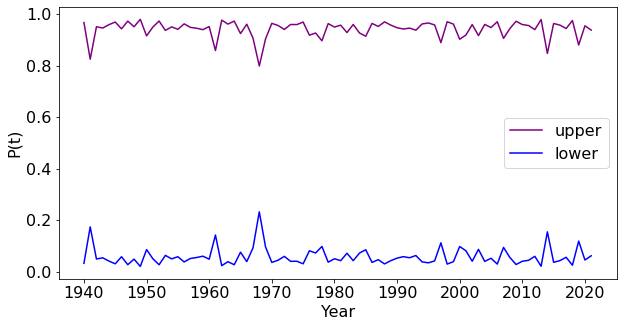

In [9]:
# plot the upper, lower bound vs. year
start = 1940
end = 2021
result = p_doy_bound(start, end)
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[0], color = 'purple', label = 'upper')
plt.plot(x, result[1], color = 'blue', label = 'lower')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("P(t)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [10]:
print(result[2])
print(result[3])
print(result[4])

[-103.92455799 -294.52843057 -105.02583126 -285.11795134 -201.26298549
 -128.07109536 -223.3876718  -117.87321353 -267.55467671 -188.674747
 -304.94498431 -286.51697576 -161.85858254 -169.93550683 -186.89165297
 -256.59553955 -109.38983706 -214.4403856  -242.05226433 -235.00194875
 -189.31689929 -317.41751787 -189.52235236  -69.67243005 -146.12119237
 -215.8882806  -197.05387188 -279.179903   -329.45497664 -278.98465553
 -191.27460618 -161.87561837 -252.98286964 -190.76313801 -277.04913353
 -238.76340598 -283.10329418 -266.24909359 -300.51359807 -173.80817889
 -240.60452601 -158.83146839 -261.39926353 -236.79833236 -233.99683391
 -115.04440206 -150.68473823 -142.54295126 -272.05176383 -226.47651401
 -241.61391276 -211.11383235 -222.34491469 -257.62795757 -218.04199332
 -206.75451607 -188.76991972 -235.63554051 -218.75121048 -216.58504636
 -317.64427008 -320.62979227 -194.53163389 -217.02277686 -176.06922828
 -183.92959856 -141.0060607  -401.76766727 -254.5268341  -155.29359934
 -155.61

## $\beta_i$ prediction

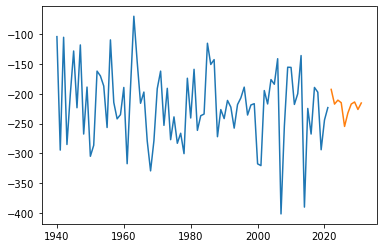

In [11]:
beta0_model = AutoReg(result[2], lags = 10, trend='c').fit()
plt.plot(range(1940, 2021+1), result[2])
plt.plot(range(2022, 2031+1), beta0_model.predict(2022-1940, 2031-1940, dynamic=False))
plt.show()

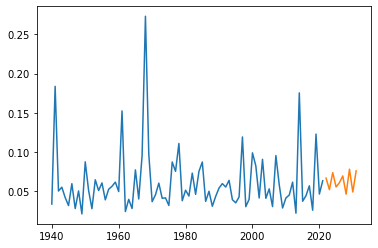

In [12]:
beta1_model = AutoReg(result[3], lags = 18, trend='c').fit()
plt.plot(range(1940, 2021+1), result[3])
plt.plot(range(2022, 2031+1), beta1_model.predict(2022-1940, 2031-1940, dynamic=False))
plt.show()

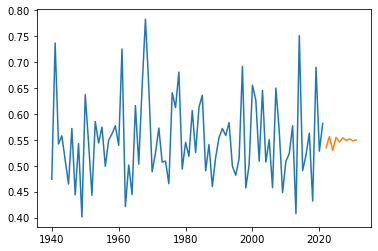

In [13]:
beta2_model = AutoReg(result[4], lags = 5, trend='c').fit()
plt.plot(range(1940, 2021+1), result[4])
plt.plot(range(2022, 2031+1), beta2_model.predict(2022-1940, 2031-1940, dynamic=False))
plt.show()

## predict doy for 2022 - 2031

In [19]:
beta0_model = AutoReg(result[2], lags = 10, trend='c').fit()
beta1_model = AutoReg(result[3], lags = 18, trend='c').fit()
beta2_model = AutoReg(result[4], lags = 5, trend='c').fit()
# predict the blooming doy
# return the predicted doy
def predict_blooming_beta_ts(start, end):
    
    training_start = 1940
    
    predict = np.zeros(end - start + 1)
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the predict doy array
        if year >= start + 1:
            CU = np.average(prediction_ds[prediction_ds['year'] == year - 1][-71:]['temp'])
        else:
            CU = np.average(train[train['year'] == year - 1][-71:]['TAVG'])
        
        pre_year = prediction_ds[prediction_ds['year'] == year][:180]
        features = ['doy', 'CDD']
        X = pre_year[features]
        
        # time series predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
        # b0 = np.array([beta0_pre[year - start]])
        if CU > 6.5:
            b0 = np.array([beta0_pre[year - start] - 50])
        else:
            b0 = np.array([beta0_pre[year - start]])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict


[ 98.  90.  93. 107.  84. 101.  97.  85.  98.  86.  77.  87.]


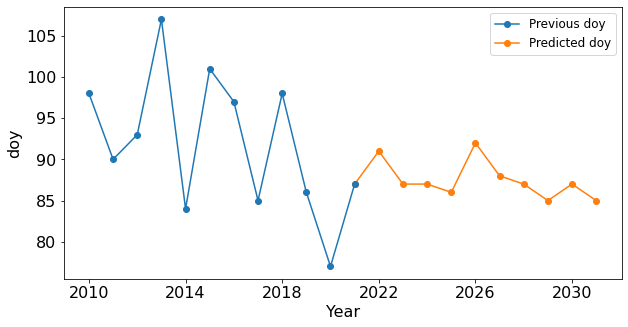

In [21]:
# plot the predict, real doy vs. year
start = 2022
end = 2031
result_pred_ts = predict_blooming_beta_ts(start, end)
x_r = np.arange(2010, 2021 + 1)
x_p = np.arange(start, end + 1)

show_start = 2010
show_end = 2021
day_bloom_array = np.zeros(show_end - show_start + 1)
for y in range(show_start, show_end + 1):
    train_y = train[train['year'] == y]
    day_bloom_array[y - show_start] = int(np.array(train_y['bloom_doy'])[0])
print(day_bloom_array)

f = plt.figure(figsize=(10, 5))
plt.plot(x_r, day_bloom_array, 'o-', label = 'Previous doy')
# plt.plot(x_p, result_pred_ts, 'o-', label = 'Predicted doy')
plt.plot(np.arange(start - 1, end + 1), np.insert(result_pred_ts, 
                                    0, day_bloom_array[-1]), 'o-', label = 'Predicted doy', zorder = 1)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
plt.xticks(np.arange(2010, 2033, 4), fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 12, loc = 'upper right')
plt.show()
f.savefig("../result_figures/Liestal_prediction.png", bbox_inches='tight', dpi=1200)

In [22]:
print(result_pred_ts)

[91. 87. 87. 86. 92. 88. 87. 85. 87. 85.]
